In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = ""



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from dcmnet.rdkit_utils import get_mol_from_id


# import pybel

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [6]:
mbis = Path("/pchem-data/meuwly/boittier/home/analysis/MBIS")
mbisdata = mbis.glob("*pkl")

In [7]:
data = {_.stem: pd.read_pickle(_) for _ in mbisdata}

In [8]:
# data

In [9]:
# list(data.keys())

In [10]:
data["dsgdb9nsd_128942"]

{'mono': array([-1.23295083e-03, -3.69578099e-04,  1.02163980e-03, ...,
        -7.55053797e-10, -7.55053797e-10, -7.55053797e-10]),
 'dipo': array([-1.34609055e-03, -5.19389763e-04,  8.33838607e-04, ...,
        -7.41842292e-10, -7.41842292e-10, -7.41842292e-10]),
 'quad': array([-1.29822647e-03, -4.46158312e-04,  9.29532874e-04, ...,
        -7.41838858e-10, -7.41838858e-10, -7.41838858e-10]),
 'esp': array([-0.00149051, -0.00068025,  0.00064643, ...,  0.        ,
         0.        ,  0.        ]),
 'closest_atom_type': array([7, 7, 1, ..., 1, 1, 1]),
 'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'rmse_mono': Array(1.7298307, dtype=float32),
 'rmse_dipo': Array(1.6037339, dtype=float32),
 'rmse_quad': Array(1.5069737, dtype=float32),
 'rmse_mono_masked': Array(0.82494813, dtype=float32),
 'rmse_dipo_masked': Array(0.6705502, dtype=float32),
 'rmse_quad_masked': Array(0.6214871, dtype=float32),
 'D_mono': Array([-0.97213125,  1.28026   , -0.43223888], dtype=float3

In [11]:
failed = pd.read_csv("/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-fails.csv")
failed = list(failed["0"])

In [12]:
data = {k:v for k,v in data.items() if k not in failed}

In [13]:
len(data.keys())

6506

In [14]:
rmse_mono_masked = [_["rmse_mono_masked"] for _ in data.values()]
rmse_dipo_masked = [_["rmse_dipo_masked"] for _ in data.values()]
rmse_quad_masked = [_["rmse_quad_masked"] for _ in data.values()]

In [15]:
np.median(np.array(rmse_mono_masked)), np.mean(np.array(rmse_mono_masked)),

(np.float32(1.0357955), np.float32(1.098358))

In [16]:
np.median(np.array(rmse_dipo_masked)), np.mean(np.array(rmse_dipo_masked)),

(np.float32(0.84949), np.float32(0.9029746))

In [17]:
np.median(np.array(rmse_quad_masked)), np.mean(np.array(rmse_quad_masked)),

(np.float32(0.76055074), np.float32(0.80239964))

In [ ]:
import rdkit
from rdkit.Chem import Draw

In [ ]:
datadir = Path("/pchem-data/meuwly/boittier/home/jaxeq/")

In [ ]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    # 126907,
    6907,
    [
        # datadir / "data/qm9-esp-dip-40000-0.npz", 
        # datadir / "data/qm9-esp-dip-40000-1.npz", 
        # datadir / "data/qm9-esp-dip-40000-2.npz", 
        datadir / "data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


In [ ]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [ ]:
import ase.data

In [ ]:
def batch_to_xyzblock(batch):
    block = ""
    xyz_str = ""
    count = 0
    for elem, xyz in zip(batch["Z"], batch["R"]):
        if elem != 0:
            count+=1
            xyz_str += "{} {}\n".format(ase.data.chemical_symbols[elem], " ".join([f"{_:.3f}" for _ in xyz]))
    block += f"{count}\n\n"
    block += xyz_str
    return block

In [ ]:
# https://greglandrum.github.io/rdkit-blog/posts/2022-12-18-introducing-rdDetermineBonds.html

from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDetermineBonds
def xyz_to_pdb_block(xyz_block):
    pdb_block = ''
    n = 0
    n_atoms = 0
    with StringIO(xyz_block) as hnd:
        while True:
            line = hnd.readline()
            if (not line):
                raise RuntimeError('XYZ block ended prematurely')
            n += 1
            if (n == 1):
                try:
                    n_atoms = int(line.strip())
                except Exception as e:
                    raise type(e)('Could not parse number of atoms on line {0:d}'.format(n)) from e
            elif (n > 2):
                try:
                    elem, x, y, z = line.strip().split()
                except Exception as e:
                    raise type(e)('Could not parse coordinate line {0:d}'.format(n)) from e
                pdb_block += 'ATOM  {0:5d} {1:>2s}   UNL     1    {2:8.3f}{3:8.3f}{4:8.3f}  1.00  0.00\n'.format(
                    n - 2, elem, float(x), float(y), float(z))
                if (n == n_atoms + 2):
                    break
    return pdb_block   

import py3Dmol
def draw_with_spheres(mol):
    v = py3Dmol.view(width=300,height=300)
    IPythonConsole.addMolToView(mol,v)
    v.zoomTo()
    v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}});
    v.show()

In [ ]:
# from pybel import readstring
import openbabel
from openbabel import pybel

In [ ]:
relax_fails = []
gdb_fails = []

for i in range(len(valid_batches)):
    batch = valid_batches[i]
    fn = str(batch["id"][0])
    block = batch_to_xyzblock(batch)
    mols = get_mol_from_id(batch)
    m0 = mols[0]
    
    try:
        smi = Chem.CanonSmiles(Chem.MolToSmiles(m0))
    except:
        smi = None
        continue
        
    mol = Chem.MolFromXYZBlock(block)
    if mol is None:
        print(f'Could not parse {fn}')
        continue
    try:
        rdDetermineBonds.DetermineBonds(mol,charge=0)
        pdb = Chem.MolToPDBBlock(mol)
        pybel_mol = pybel.readstring("pdb", pdb)
        mol2_string = pybel_mol.write("mol2")
        with open(Path("/pchem-data/meuwly/boittier/home/jaxeq/") / f"{fn}.mol2", "w") as f:
            f.write(mol2_string)
    except:
        print("determine bonds failed")
        continue


    
    # remove double bond stereo:
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            bond.SetStereo(Chem.BondStereo.STEREONONE)
        elif bond.GetBondType() == Chem.BondType.SINGLE:
            bond.SetBondDir(Chem.BondDir.NONE)
    osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
    # compare to relax_smi:
    # print(smi, osmi)
    if smi!=osmi:
        relax_fails.append((fn,smi,osmi))
        gdb_smi=smi
        # that failed, so next we are going to compare to gdb_smi;
        try:
            smi = Chem.CanonSmiles(gdb_smi)
        except:
            continue
        # the GDB smiles don't have any stereo at all, so get rid of atomic stereo
        for atom in mol.GetAtoms():
            atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
        if smi != osmi:
            gdb_fails.append((fn,smi,osmi))
        

In [ ]:
import ase


In [3]:
ase_obj = ase.Atoms(batch["Z"], batch["R"])
ase.visualize.view(ase_obj, viewer="x3d")


NameError: name 'ase' is not defined

In [4]:
mol = Chem.MolFromXYZBlock(block)
if mol is None:
    print(f'Could not parse {fn}')
rdDetermineBonds.DetermineBonds(mol,charge=0)

draw_with_spheres(mol)

NameError: name 'Chem' is not defined

In [106]:
draw_with_spheres(m0)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [173]:
gdb_fails

[('dsgdb9nsd_121896', 'COCCC([NH3+])C(=O)[O-]', 'COCCC(N)C(=O)O'),
 ('dsgdb9nsd_060635', '[NH3+]C1CC1C(O)C(=O)[O-]', 'NC1CC1C(O)C(=O)O'),
 ('dsgdb9nsd_098239', 'CNC(=O)C([NH3+])C(=O)[O-]', 'CNC(=O)C(N)C(=O)O'),
 ('dsgdb9nsd_005598', '[NH3+]Cc1ccoc1[O-]', 'NCc1ccoc1O'),
 ('dsgdb9nsd_102795', 'N=COC(C[NH3+])C(=O)[O-]', 'NCC1OC(N)OC1=O'),
 ('dsgdb9nsd_060429', 'CC(C)[NH2+]CCC(=O)[O-]', 'CC(C)NCCC(=O)O'),
 ('dsgdb9nsd_022265', 'CC(=N[O-])C1(O)C[NH2+]C1', 'CC(=[NH+][O-])C1(O)CNC1'),
 ('dsgdb9nsd_006792', '[NH3+]CCOCC(=O)[O-]', 'NCCOCC(=O)O'),
 ('dsgdb9nsd_086827', '[NH3+]C1CC(CC(=O)[O-])C1', 'NC1CC(CC(=O)O)C1'),
 ('dsgdb9nsd_127895', 'CN=c1nnoc(O)n1', 'CN=C=NC(=O)O.N#N'),
 ('dsgdb9nsd_113165', 'CCC1CC1([NH3+])C(=O)[O-]', 'CCC1CC1(N)C(=O)O'),
 ('dsgdb9nsd_054179', 'CC1(C(=O)[O-])CN1C=[NH2+]', 'CC12CN1C(N)OC2=O'),
 ('dsgdb9nsd_101926', 'C[NH2+]C(C(=O)[O-])C1CN1', 'CNC(C(=O)O)C1CN1'),
 ('dsgdb9nsd_037993', 'C1=C2CC3N=C1N1C2C31', 'C=C1C=C2N=CC3C1N23'),
 ('dsgdb9nsd_130402', 'N#Cc1[n-]nnc1C[NH3+

In [180]:
len(relax_fails)

85151

In [112]:
parms = list(Path("/pchem-data/meuwly/boittier/home/qm9mol2").glob("*parm"))

In [214]:
parms

[PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126730.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126731.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126732.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126733.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126734.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126735.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126736.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126737.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126738.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126739.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126740.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126741.mol2.parm'),
 Pos

In [216]:
cgenff_parms = {}
for fn in parms:
    with open(fn) as f:
        lines = f.readlines()
        atoms = []
        for _ in lines:
            if _.__contains__("ATOM"):
                atoms.append(_)
        qm9_key = str(fn.stem).strip(".mol2")
        print(qm9_key)
        qm9_key = "dsgdb9nsd_" + "{:06}".format(int(qm9_key.split("_")[1]))
        print(qm9_key)
        cgenff_parms[qm9_key] = atoms

dsgdb9nsd_126730
dsgdb9nsd_126730
dsgdb9nsd_126731
dsgdb9nsd_126731
dsgdb9nsd_12673
dsgdb9nsd_012673
dsgdb9nsd_126733
dsgdb9nsd_126733
dsgdb9nsd_126734
dsgdb9nsd_126734
dsgdb9nsd_126735
dsgdb9nsd_126735
dsgdb9nsd_126736
dsgdb9nsd_126736
dsgdb9nsd_126737
dsgdb9nsd_126737
dsgdb9nsd_126738
dsgdb9nsd_126738
dsgdb9nsd_126739
dsgdb9nsd_126739
dsgdb9nsd_126740
dsgdb9nsd_126740
dsgdb9nsd_126741
dsgdb9nsd_126741
dsgdb9nsd_12674
dsgdb9nsd_012674
dsgdb9nsd_126743
dsgdb9nsd_126743
dsgdb9nsd_126744
dsgdb9nsd_126744
dsgdb9nsd_126745
dsgdb9nsd_126745
dsgdb9nsd_126746
dsgdb9nsd_126746
dsgdb9nsd_126747
dsgdb9nsd_126747
dsgdb9nsd_126748
dsgdb9nsd_126748
dsgdb9nsd_126749
dsgdb9nsd_126749
dsgdb9nsd_126750
dsgdb9nsd_126750
dsgdb9nsd_126751
dsgdb9nsd_126751
dsgdb9nsd_12675
dsgdb9nsd_012675
dsgdb9nsd_126754
dsgdb9nsd_126754
dsgdb9nsd_126755
dsgdb9nsd_126755
dsgdb9nsd_126756
dsgdb9nsd_126756
dsgdb9nsd_126757
dsgdb9nsd_126757
dsgdb9nsd_126758
dsgdb9nsd_126758
dsgdb9nsd_126759
dsgdb9nsd_126759
dsgdb9nsd_126760


In [203]:
cgenff_parms["dsgdb9nsd_126730"]

['ATOM C1     CG331  -0.258 !    2.250\n',
 'ATOM C2     CG321   0.057 !   26.273\n',
 'ATOM N1     NG2R61 -0.054 !  176.867\n',
 'ATOM C3     CG2R61 -0.253 !   43.984\n',
 'ATOM C4     CG2R61 -0.137 !   34.664\n',
 'ATOM C5     CG2R64  0.976 !   22.663\n',
 'ATOM N2     NG2D1  -0.875 !   14.402\n',
 'ATOM N3     NG2R62 -0.433 !   26.449\n',
 'ATOM N4     NG2R62 -0.167 !  177.634\n',
 'ATOM H1     HGA3    0.090 !    0.000\n',
 'ATOM H2     HGA3    0.090 !    0.000\n',
 'ATOM H3     HGA3    0.090 !    0.000\n',
 'ATOM H4     HGA2    0.090 !    2.250\n',
 'ATOM H5     HGA2    0.090 !    2.250\n',
 'ATOM H6     HGR62   0.220 !   27.040\n',
 'ATOM H7     HGR61   0.154 !    0.000\n',
 'ATOM H8     HGP1    0.320 !    0.000\n']

In [209]:
[str(_["id"][0]) for _ in valid_batches[:10]]

['dsgdb9nsd_131371',
 'dsgdb9nsd_132759',
 'dsgdb9nsd_126821',
 'dsgdb9nsd_133460',
 'dsgdb9nsd_131240',
 'dsgdb9nsd_130519',
 'dsgdb9nsd_131833',
 'dsgdb9nsd_128509',
 'dsgdb9nsd_131838',
 'dsgdb9nsd_132401']

In [204]:
def str_to_alpha(s):
    return "".join(filter(lambda x: x.isalpha(), s))

In [219]:
valid_ids = set([str(_["id"][0]) for _ in valid_batches if str(_["id"][0])])

In [220]:
valid_ids

{'dsgdb9nsd_132931',
 'dsgdb9nsd_127304',
 'dsgdb9nsd_128829',
 'dsgdb9nsd_133526',
 'dsgdb9nsd_126721',
 'dsgdb9nsd_126986',
 'dsgdb9nsd_133772',
 'dsgdb9nsd_131288',
 'dsgdb9nsd_132388',
 'dsgdb9nsd_129268',
 'dsgdb9nsd_133630',
 'dsgdb9nsd_132200',
 'dsgdb9nsd_131410',
 'dsgdb9nsd_131127',
 'dsgdb9nsd_128957',
 'dsgdb9nsd_130730',
 'dsgdb9nsd_131629',
 'dsgdb9nsd_132086',
 'dsgdb9nsd_131316',
 'dsgdb9nsd_132229',
 'dsgdb9nsd_132918',
 'dsgdb9nsd_131795',
 'dsgdb9nsd_131311',
 'dsgdb9nsd_133682',
 'dsgdb9nsd_133654',
 'dsgdb9nsd_131960',
 'dsgdb9nsd_127484',
 'dsgdb9nsd_133581',
 'dsgdb9nsd_128224',
 'dsgdb9nsd_131057',
 'dsgdb9nsd_129526',
 'dsgdb9nsd_127344',
 'dsgdb9nsd_133092',
 'dsgdb9nsd_130305',
 'dsgdb9nsd_133551',
 'dsgdb9nsd_133146',
 'dsgdb9nsd_128305',
 'dsgdb9nsd_127677',
 'dsgdb9nsd_130254',
 'dsgdb9nsd_129421',
 'dsgdb9nsd_128757',
 'dsgdb9nsd_131862',
 'dsgdb9nsd_127863',
 'dsgdb9nsd_131677',
 'dsgdb9nsd_129910',
 'dsgdb9nsd_130694',
 'dsgdb9nsd_131291',
 'dsgdb9nsd_1

In [222]:
keys = list(cgenff_parms.keys())
cgenff_keys = set(keys)

In [227]:
len(cgenff_keys)

6588

In [228]:
len(valid_ids)

6621

In [226]:
len(cgenff_keys & valid_ids)

5926

In [235]:
qm9_id = []
atom_id = []
mbis_q = []
cgenff_q = []
elements = []

for key in keys:
    elem = [str_to_alpha(str(_.split()[1])) for _ in cgenff_parms[key]]
    cgenff_charges = [float(_.split()[3]) for _ in cgenff_parms[key]]
    cgenff_atomtypes = [str(_.split()[2]) for _ in cgenff_parms[key]]
    try:
        batch = [_ for _ in valid_batches if str(_["id"][0]) == key][0]
        nonzero = batch["Z"] != 0
        mono = batch["mono"][nonzero]
    except Exception as e:
        # print(e, key)
        mono = []
    
    if len(mono) > 0 and len(cgenff_atomtypes) == len(mono):
        # assert len(cgenff_atomtypes) == len(mono), "{} {}".format(len(cgenff_atomtypes), len(mono))
        for i in range(len(mono)):
            qm9_id.append(key)
            atom_id.append(cgenff_atomtypes[i])
            mbis_q.append(mono[i])
            cgenff_q.append(cgenff_charges[i])
            elements.append(elem[i])


In [236]:
charge_comparison = pd.DataFrame({
    "qm9_id": qm9_id,
     "atom_id": atom_id,
     "element": elements,
     "mbis_q": mbis_q,
     "cgenff_q": cgenff_q,
             })

In [241]:
len(charge_comparison["qm9_id"].unique())

5913

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def scatter_dens(x, y):

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # Sort points by density (for better visualization)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c=z, s=50, cmap='viridis')
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot Colored by Point Density')
    plt.show()

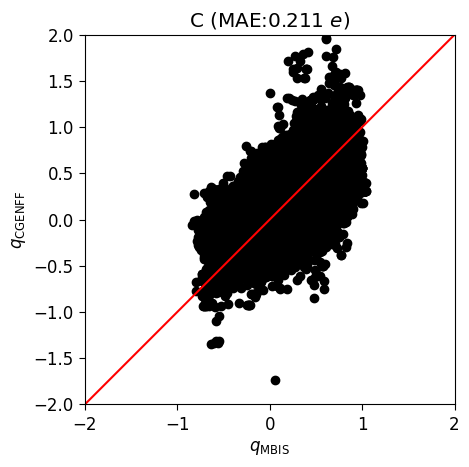

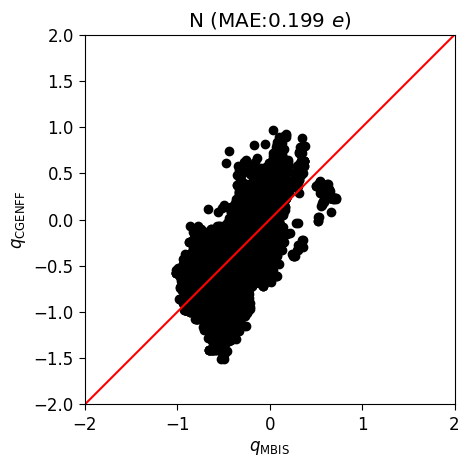

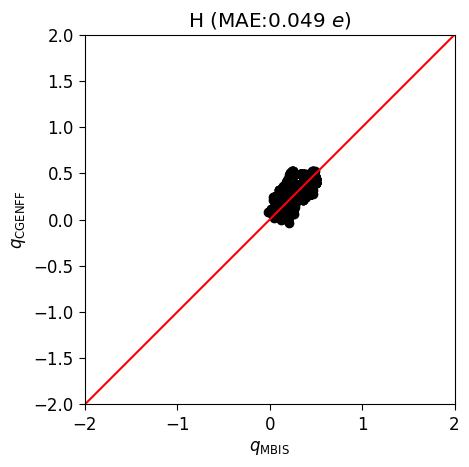

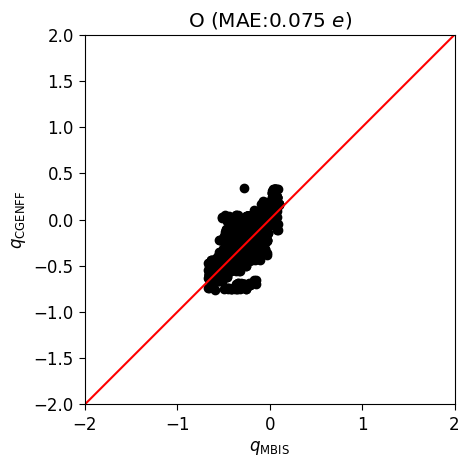

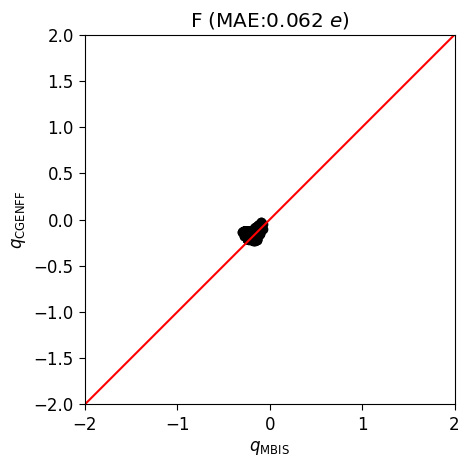

In [273]:
for element in charge_comparison.element.unique():
    _ = charge_comparison[charge_comparison["element"] == element]
    plt.scatter(_["mbis_q"], _["cgenff_q"], alpha=1, color="k")
    plt.plot([-2,2], [-2,2], c="r")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xlabel(r"$q_{\mathrm{MBIS}}$")
    plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
    plt.gca().set_aspect("equal")
    MAE =np.mean(abs( _["mbis_q"] - _["cgenff_q"]))
    title = f"{element} (MAE:{MAE:.3f} $e$)"
    plt.title(title)
    plt.show()

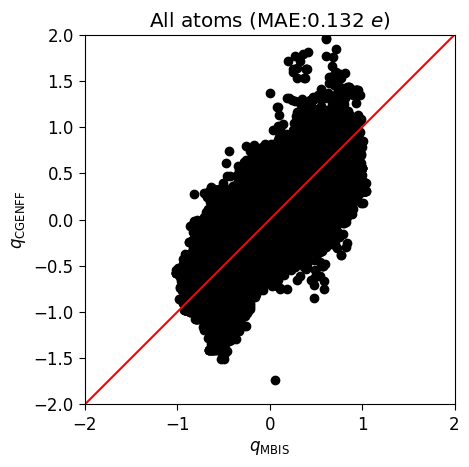

In [274]:
plt.scatter(charge_comparison["mbis_q"], charge_comparison["cgenff_q"], alpha=1, color="k")
plt.plot([-2,2], [-2,2], c="r")
plt.xlim(-2,2)
plt.ylim(-2,2)
MAE =np.mean(abs( charge_comparison["mbis_q"] - charge_comparison["cgenff_q"]))
title = f"All atoms (MAE:{MAE:.3f} $e$)"
plt.title(title)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
plt.gca().set_aspect("equal")

In [295]:
# "_".join([str(_) for _ in [Path("/test"), Path("/test")]])

'/test_/test'

In [291]:
import optax
np.mean(optax.l2_loss(charge_comparison["mbis_q"], charge_comparison["cgenff_q"]))

np.float64(0.01917653035209648)

In [292]:
np.mean(optax.l2_loss(charge_comparison["mbis_q"], charge_comparison["cgenff_q"]*0))

np.float64(0.06907889989155569)

In [1]:
MAE =np.mean(abs( charge_comparison["mbis_q"] - charge_comparison["cgenff_q"]))

NameError: name 'np' is not defined

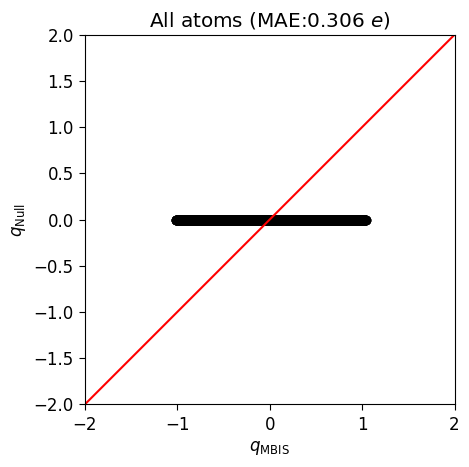

In [275]:
plt.scatter(charge_comparison["mbis_q"], charge_comparison["cgenff_q"]*0, alpha=1, color="k")
plt.plot([-2,2], [-2,2], c="r")
plt.xlim(-2,2)
plt.ylim(-2,2)
MAE =np.mean(abs( charge_comparison["mbis_q"] - charge_comparison["cgenff_q"]*0))
title = f"All atoms (MAE:{MAE:.3f} $e$)"
plt.title(title)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{Null}}$")
plt.gca().set_aspect("equal")

In [133]:
plt.scatter(charge_comparison["mbis_q"], charge_comparison["cgenff_q"], alpha=0.01, color="k")
plt.plot([-2,2], [-2,2], c="r")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
plt.gca().set_aspect("equal")

In [134]:
batch["mono"][nonzero]

array([-0.47088664, -0.10475539,  0.0377145 , -0.02745989, -0.34160904,
        0.56882062, -0.7696491 , -0.30255123, -0.04012136,  0.15759753,
        0.14847546,  0.16479985,  0.12106948,  0.14825589,  0.15621546,
        0.20332931,  0.35078937])

In [142]:
np.sum(cgenff_charges), np.sum(batch["mono"][nonzero])

(np.float64(5.551115123125783e-17), np.float64(3.4817794384023326e-05))

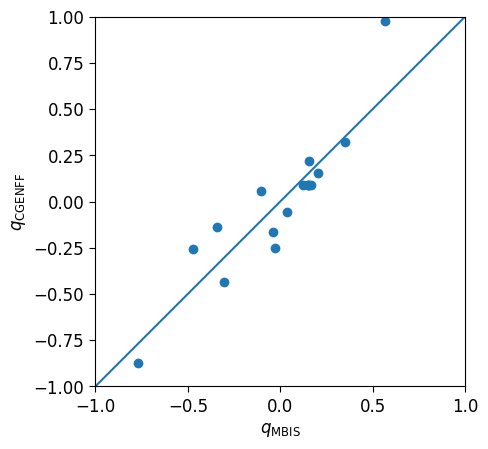

In [158]:
plt.scatter(batch["mono"][nonzero], cgenff_charges)
plt.plot([-1,1], [-1,1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
plt.gca().set_aspect("equal")

In [175]:
df = pd.read_csv("/pchem-data/meuwly/boittier/home/jaxeq/data/qm9.csv")
df

,Unnamed: 0.1,Unnamed: 0,inchi,smiles,rotational_constant_a,rotational_constant_b,rotational_constant_c,dipole_moment,polarizability,homo,lumo,gap,r2,zero_point_energy,u0,u298,h298,g298,heat_capacity
0,0,0,InChI=1S/CH4/h1H4,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469
1,1,1,InChI=1S/H3N/h1H3,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316
2,2,2,InChI=1S/H2O/h1H2,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002
3,3,3,InChI=1S/C2H2/c1-2/h1-2H,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574
4,4,4,InChI=1S/CHN/c1-2/h1H,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133880,133880,133880,"InChI=1S/C7H7NO/c1-2-4-3-5-6(8(2)4)7(1,3)9-5/h...",C1C2C3C4C5OC14C5N23,3.59483,2.198990,1.904230,1.6637,69.37,-0.2254,0.0588,0.2842,760.7472,0.127406,-400.633868,-400.628599,-400.627654,-400.663098,23.658
133881,133881,133881,InChI=1S/C7H7NO/c1-7-2-4-5(8(1)4)3(7)6(2)9-7/h...,C1N2C3C2C2C4OC12C34,3.65648,2.142370,1.904390,1.2976,69.52,-0.2393,0.0608,0.3002,762.6354,0.127495,-400.629713,-400.624444,-400.623500,-400.658942,23.697
133882,133882,133882,InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...,C1N2C3C4C5C2C13CN45,3.67118,2.143140,1.895010,1.2480,73.60,-0.2233,0.0720,0.2953,780.3553,0.140458,-380.753918,-380.748619,-380.747675,-380.783148,23.972
133883,133883,133883,InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...,C1N2C3C4C5CC13C2C45,3.52845,2.151310,1.865820,1.9576,77.40,-0.2122,0.0881,0.3003,803.1904,0.152222,-364.720374,-364.714974,-364.714030,-364.749650,24.796


In [176]:
pd.DataFrame(gdb_fails).to_csv("qm9-fails.csv", index=False)

In [177]:
fails = []
for i in range(len(gdb_fails)):
    fails.append(Chem.MolFromSmiles(gdb_fails[i][1]))
    fails.append(Chem.MolFromSmiles(gdb_fails[i][2]))


In [178]:
len(fails) // 2

1711

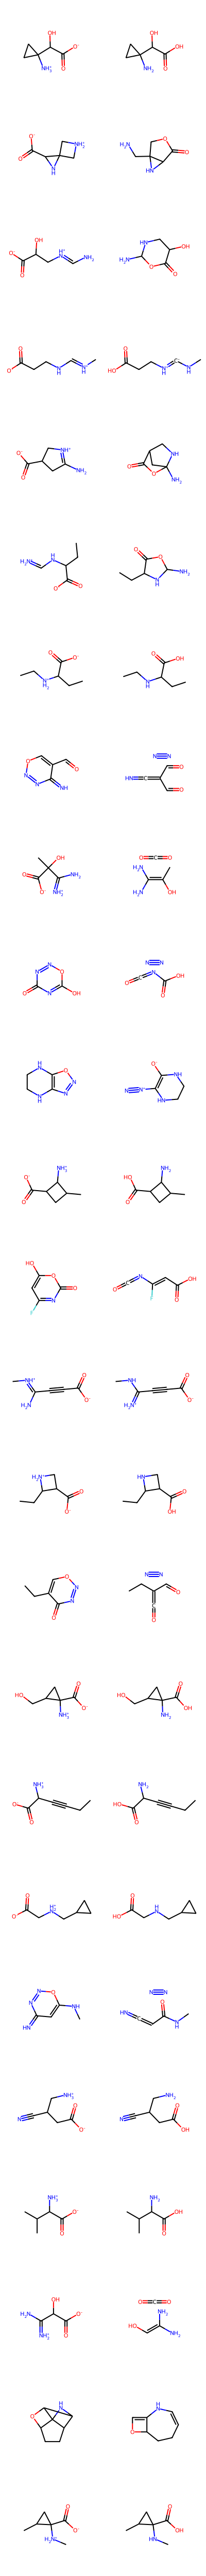

In [182]:
Draw.MolsToGridImage(fails[400:], molsPerRow=2)

In [49]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.patches as mpatches


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}


In [50]:
colors = {"dcm-1": "y", "dcm-2": "r", "dcm-3": "g", "dcm-4": "b", }

In [51]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

In [136]:
def plot_validation(run, data_label = "Loss/valid"):
    files = {_.parents[0].name: _ for _ in list(ddir.glob(f"{run}/*/best*"))}
    KEYS = list(files.keys())
    # for i, _ in enumerate(KEYS):
    #     print(i, _)
    fig, ax = plt.subplots()
    for i, k in enumerate(KEYS[:]):
        file = files[KEYS[i]].parents[0]
        _ = parse_tensorboard(str(file), 
                          [data_label])
        dcm = "dcm-"+k.split("-")[2]
        _[data_label].plot("step", "value", ax=ax, 
                             color=colors[dcm],
                              alpha=0.6)
    # plt.xscale("log")
    dc1_patch = mpatches.Patch(color='y', label='dcm-1')
    dc2_patch = mpatches.Patch(color='r', label='dcm-2')
    dc3_patch = mpatches.Patch(color='g', label='dcm-3')
    dc4_patch = mpatches.Patch(color='b', label='dcm-4')
    ax.legend(handles=[dc1_patch, dc2_patch, dc3_patch, dc4_patch], 
              loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_ylim(0.0001, 0.1)
    ax.set_yscale("log")
    plt.ylabel("Validation loss", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)

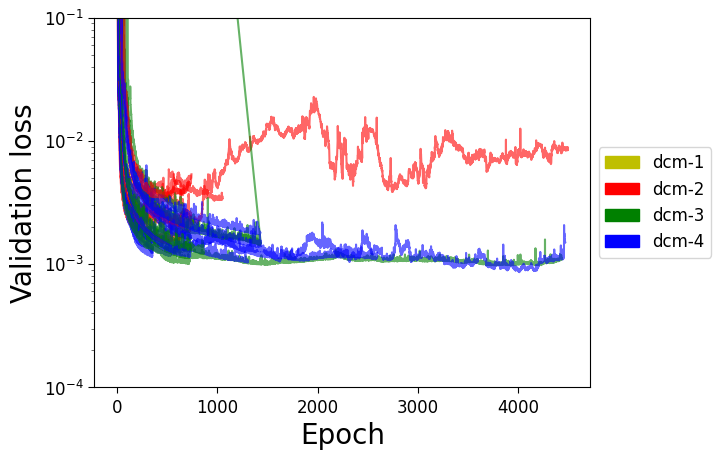

In [146]:
plot_validation("runs2")

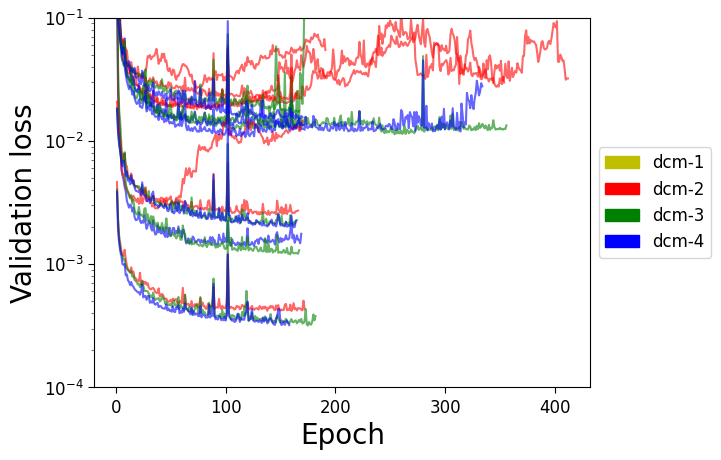

In [147]:
plot_validation("runs4")

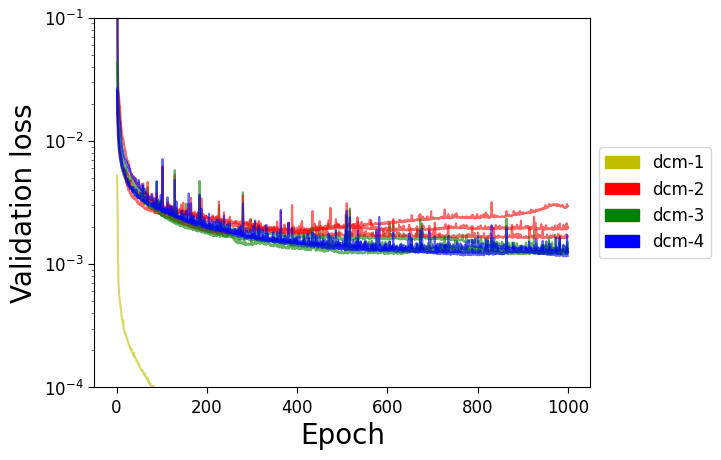

In [148]:
plot_validation("runs5")

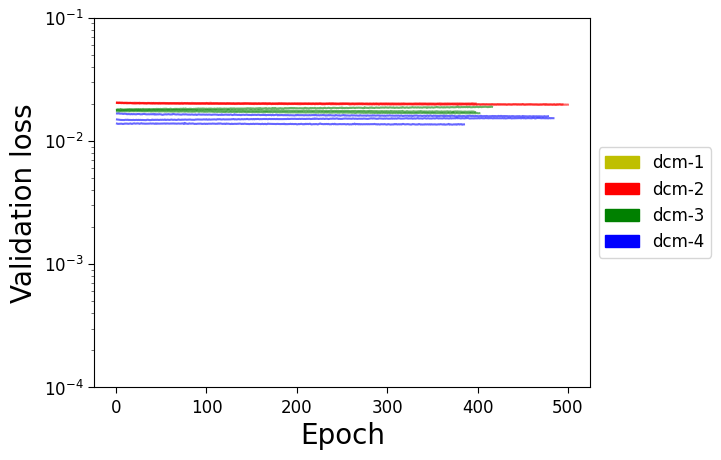

In [149]:
plot_validation("runs888")

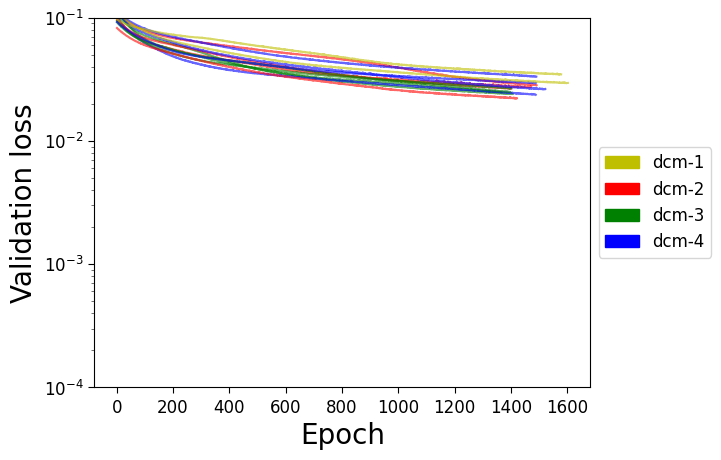

In [150]:
plot_validation("test2")

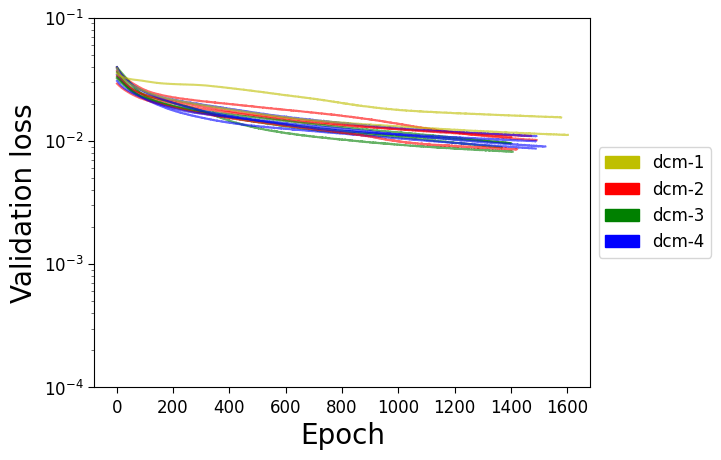

In [151]:
plot_validation("test2", "esp_l/valid")

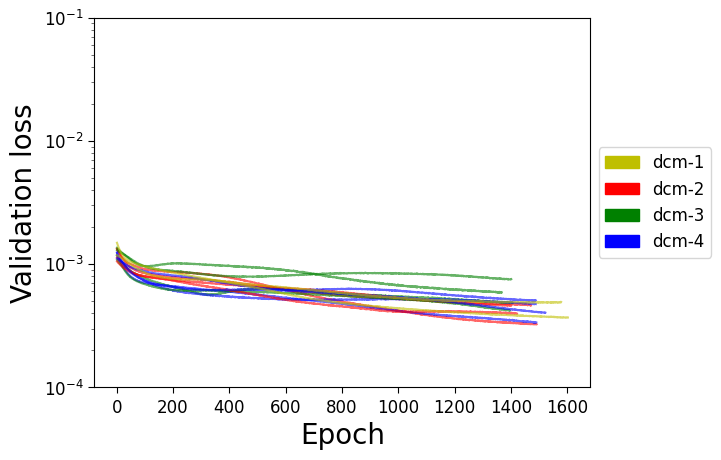

In [152]:
plot_validation("test2", "mono_l/valid")

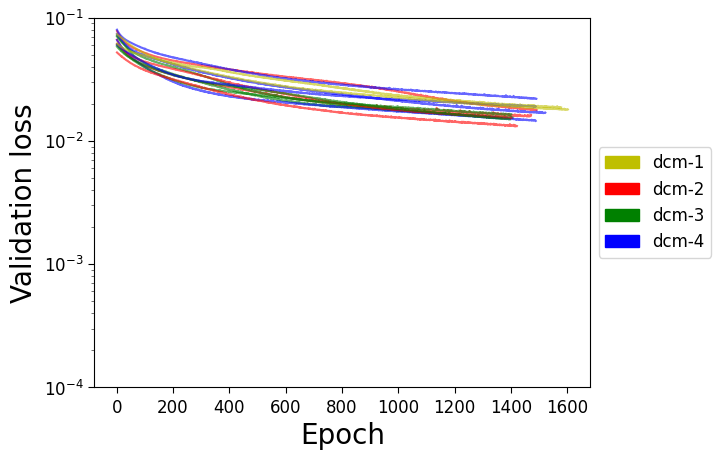

In [153]:
plot_validation("test2", "dipo_l/valid")

In [84]:
from dcmnet.analysis import create_model_and_params

In [85]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")
p = ddir / "test2/20240926-201945dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-200343dcm-4-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"
p = ddir / "test2/20240926-195425dcm-3-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"

# name1/

#

In [25]:
model, params = create_model_and_params(p, debug=True)


{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 3.0, 'include_pseudotensors': True, 'debug': True}


In [26]:
model

MessagePassingModelDEBUG(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
    include_pseudotensors = True
)

In [27]:
params["params"]["TensorDense_0"]["dense"]["1-"]["kernel"].shape

(16, 6)

In [28]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
                Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
        # Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-40000-0.npz"#"data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [29]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [30]:
batch = valid_batches[0]

In [31]:
rotated_batch = batch.copy()

In [32]:
import e3x
R = e3x.so3.random_rotation(data_key)

In [33]:
idxs = []
for _ in np.nonzero(batch["Z"])[0]:
    for i in range(4):
        idxs.append(_*4+i)
idxs = np.array(idxs)

In [34]:
rotated_batch["vdw_surface"].shape

(1, 3200, 3)

In [35]:
rotated_batch["R"] = rotated_batch["R"]@R
rotated_batch["vdw_surface"] = rotated_batch["vdw_surface"]@R

In [36]:
rotated_batch["vdw_surface"].shape

(1, 3200, 3)

In [37]:
mono, dipo = apply_model(model, params, batch, 1)

# error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
#                                   1, model.n_dcm,
#                                        plot=True,
#                                        id=True,
#                               )

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [38]:
np.linalg.norm(dipo[idxs], axis=-1)

array([0.03995881, 0.10634533, 0.03978472, 0.00616987, 0.03062055,
       0.05337867, 0.04492039, 0.01497616, 0.04344733, 0.04453675,
       0.00699067, 0.06575396, 0.00506741, 0.01556755, 0.04078629,
       0.00647742, 0.02006987, 0.04589762, 0.06410828, 0.00860288,
       0.06605298, 0.01414999, 0.01192929, 0.05851729, 0.05595624,
       0.00548513, 0.07159785, 0.00513485, 0.02364565, 0.02981395,
       0.01676863, 0.06389601, 0.06111143, 0.02610966, 0.00222256,
       0.00603913, 0.01404219, 0.04858905, 0.04303575, 0.00557803,
       0.04516298, 0.03242366, 0.00557803, 0.04516298, 0.03242366,
       0.00557803, 0.04516298, 0.03242366, 0.00557803, 0.04516298,
       0.03242366, 0.00557803], dtype=float32)

In [39]:
mono, dipo = apply_model(model, params, rotated_batch, 1)

# error, esp, keys, _ = evaluate_dc(rotated_batch, dipo, mono, 
#                                   1, model.n_dcm,
#                                        plot=True,
#                                        id=True,
#                               )

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [40]:
np.linalg.norm(dipo[idxs], axis=-1)

array([0.03995879, 0.10634539, 0.03978472, 0.00616989, 0.03062049,
       0.05337872, 0.04492035, 0.01497621, 0.04344734, 0.04453674,
       0.00699066, 0.06575391, 0.00506741, 0.01556754, 0.04078615,
       0.00647742, 0.02006992, 0.0458976 , 0.06410825, 0.00860285,
       0.06605277, 0.01415   , 0.01192928, 0.0585173 , 0.05595611,
       0.00548512, 0.07159777, 0.00513486, 0.02364567, 0.02981398,
       0.01676865, 0.06389603, 0.06111143, 0.02610967, 0.00222256,
       0.00603914, 0.01404219, 0.04858906, 0.04303575, 0.00557803,
       0.04516306, 0.03242369, 0.00557803, 0.04516306, 0.03242369,
       0.00557803, 0.04516306, 0.03242369, 0.00557803, 0.04516306,
       0.03242369, 0.00557803], dtype=float32)

In [41]:
m,d = model.apply(params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=1,)

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [42]:
d.shape

(60, 3, 3)